# Load the Raw Data

In [1]:
%%bash
wget https://raw.githubusercontent.com/eladsegal/strategyqa/refs/heads/main/data/strategyqa/train.json

--2025-06-06 06:57:19--  https://raw.githubusercontent.com/eladsegal/strategyqa/refs/heads/main/data/strategyqa/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3857762 (3.7M) [text/plain]
Saving to: ‘train.json’

     0K .......... .......... .......... .......... ..........  1% 7.01M 1s
    50K .......... .......... .......... .......... ..........  2% 7.87M 0s
   100K .......... .......... .......... .......... ..........  3% 43.7M 0s
   150K .......... .......... .......... .......... ..........  5% 31.9M 0s
   200K .......... .......... .......... .......... ..........  6% 80.8M 0s
   250K .......... .......... .......... .......... ..........  7% 13.4M 0s
   300K .......... .......... .......... .......... ..........  9% 75.3M 0s
   350K ....

In [2]:
import pandas as pd

raw_data_path='/kaggle/working/train.json'

df = pd.read_json(raw_data_path)
df.head(5)

,qid,term,description,question,answer,facts,decomposition,evidence
0,2bc9c4f9c19c167187f2,Genghis Khan,founder and first Great Khan of the Mongol Empire,Are more people today related to Genghis Khan ...,True,"[Julius Caesar had three children., Genghis Kh...","[How many kids did Julius Caesar have?, How ma...","[[[['Caesarion-2', 'Julia (daughter of Caesar)..."
1,03caf265939fab701dee,The Police,English rock band,Could the members of The Police perform lawful...,False,"[The members of The Police were musicians, not...","[Who can perform lawful arrests?, Are members ...","[[[['Arrest-2']], [[""Citizen's arrest-2"", 'The..."
2,aadc8000bfcb987d6b9d,Depression (mood),state of low mood and fatigue,Would a Monoamine Oxidase candy bar cheer up a...,False,[Depression is caused by low levels of seroton...,[Depression is caused by low levels of what ch...,"[[[['Monoamine oxidase-8']], [['Monoamine oxid..."
3,d1a138ecfa13ee277ab4,Grey seal,species of seal,Would a dog respond to bell before Grey seal?,True,[Grey seals have no ear flaps and their ears c...,[How sensitive is a grey seal's hearing on lan...,"[[[['Pinniped-24']], [['Hearing range-11', 'He..."
4,f945d8a4274bb3805989,Pound sterling,Official currency of the United Kingdom and ot...,Is a pound sterling valuable?,False,"[A pound sterling is fiat money., Fiat money i...",[What is the value of the Pound Sterling based...,"[[[['Pound sterling-16']], [['Pound sterling-1..."


In [3]:
df.shape

(2061, 8)

In [4]:
df_shuffle=df.sample(frac=1).reset_index(drop=True).head(1200)
df_shuffle.head(5)

,qid,term,description,question,answer,facts,decomposition,evidence
0,9a48326a1e2daeb57c42,Sunday,day of the week,Is Christmas always celebrated on a Sunday?,False,[Christmas is always celebrated on December 25...,"[What date does Christmas fall on each year?, ...","[[[['Christmas-1']], [['Sunday-1'], operation]..."
1,aafd1651752696bdfb6e,Ariana Grande,"American singer, songwriter, and actress",Was Ariana Grande inspired by Imogen Heap?,True,[Ariana Grande's song 'Goodnight And Go' uses ...,[Who was the original singer of Ariana Grande'...,"[[[['Goodnight and Go-1', 'Sweetener (song)-1'..."
2,b9cfeab1d1d3d8f99e78,Alice in Wonderland (1951 film),1951 American animated musical fantasy film pr...,Does Disney's Alice in Wonderland involve the ...,True,"[In the movie, Alice meets the Mad Hatter., Th...",[What celebrations were featured in the Disney...,"[[[['Alice in Wonderland (1951 film)-7']], [op..."
3,6a0aa197f710fbbf097d,Hepatitis,inflammation of the liver tissue,Can you cure hepatitis with a tonsillectomy?,False,"[A tonsillectomy removes the tonsils, glands f...","[What organ does hepatitis affect? , What orga...","[[[['Hepatitis-1']], [['Tonsillectomy-1']], [o..."
4,09f8567b988353bc084c,4,Natural number,Would four shoes be insufficient for a set of ...,True,[There are eight children in a set of octuplet...,"[How many children are in a set of octuplets?,...","[[[['Multiple birth-6']], [['Shoe-1']], [opera..."


In [5]:
df_shuffle.shape

(1200, 8)

In [6]:
first=df_shuffle.iloc[0]

print(first['question'])
print(first['facts'])
print(first['evidence'])
print(first['answer'])

Is Christmas always celebrated on a Sunday?
['Christmas is always celebrated on December 25.', 'A specific date on the calendar rotates to the following day of the week each year.', 'Christmas can therefore be any day of the week.']
[[[['Christmas-1']], [['Sunday-1'], 'operation']], [[['Christmas-3']], [['Christmas-3']]], [[['Christmas-1']], [['Christmas Sunday-2']]]]
False


# Creating Multiple Reasoning Paths

In [7]:
from typing import Optional, List
from pydantic import BaseModel

class Entity(BaseModel):
    qid: str
    term: str
    description: str
    question: str
    answer: bool
    facts: list
    decomposition: list
    evidence: list

class ReasoningPath(BaseModel):
    question: str
    evidence: List[str] # for original facts
    reason: str
    answer: str
    ground_truth: bool
    temperature: float
    tokens: int
    score: float

entities = [Entity.model_validate(row) for row in df_shuffle.to_dict(orient='records')]
print(len(entities))
print(entities[0])

1200
qid='9a48326a1e2daeb57c42' term='Sunday' description='day of the week' question='Is Christmas always celebrated on a Sunday?' answer=False facts=['Christmas is always celebrated on December 25.', 'A specific date on the calendar rotates to the following day of the week each year.', 'Christmas can therefore be any day of the week.'] decomposition=['What date does Christmas fall on each year?', 'Does #1 always fall on a Sunday?'] evidence=[[[['Christmas-1']], [['Sunday-1'], 'operation']], [[['Christmas-3']], [['Christmas-3']]], [[['Christmas-1']], [['Christmas Sunday-2']]]]


In [8]:
import re
from sot.sot import SoT
from typing import Tuple, Union
from doraemon.logger_util import get_logger
from doraemon.inference_factory import InferenceFactory

logger=get_logger(name=__name__, logfile="strategy_qa_dataset_builder.log")

def get_answer(raw_answer: str)-> str:
    answer=re.search(r"\\boxed\{(.*?)\}", raw_answer)
    if answer:
        return answer.group(1)
    return None
    

def process_entity(args)-> Optional[Tuple[ReasoningPath, int]]:
    """
    """
    entity,paradigm,temperature=args

    try:
        prompt=SoT.get_initialized_prompt(paradigm=paradigm, question=f"Evidences:{entity.facts}\nQuestion:{entity.question}")
        r_s, tokens=InferenceFactory.inference(logger=logger, messages=prompt, temperature=temperature)
        result=ReasoningPath(
            question=str(entity.question), 
            evidence=entity.facts, 
            reason=str(r_s), 
            answer=get_answer(r_s),
            ground_truth=bool(entity.answer),
            temperature=float(temperature), 
            tokens=int(tokens), 
            score=0.0)
        return result, tokens
    except Exception as e:
        logger.error(f"Error processing quetion {entity.question} at temperature {temperature} with exception {e}")
        return None


paradigm = SoT.classify_question(entities[0].question)
logger.info(paradigm)
assert "conceptual_chaining"==str(paradigm)

2025-06-06 06:57:37.405292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749193057.584487      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749193057.640013      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-06-06 06:57:54,310 INFO conceptual_chaining


In [9]:
temperatures = [i * 0.25 for i in range(9)]  # [0.0, 0.25, 0.5, ... ,2.0]

tasks=[]
for et in entities:
    for tp in temperatures:
        tasks.append((et,paradigm,tp))
tasks[0]

(Entity(qid='9a48326a1e2daeb57c42', term='Sunday', description='day of the week', question='Is Christmas always celebrated on a Sunday?', answer=False, facts=['Christmas is always celebrated on December 25.', 'A specific date on the calendar rotates to the following day of the week each year.', 'Christmas can therefore be any day of the week.'], decomposition=['What date does Christmas fall on each year?', 'Does #1 always fall on a Sunday?'], evidence=[[[['Christmas-1']], [['Sunday-1'], 'operation']], [[['Christmas-3']], [['Christmas-3']]], [[['Christmas-1']], [['Christmas Sunday-2']]]]),
 'conceptual_chaining',
 0.0)

In [10]:
from tqdm import tqdm
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    results=list(tqdm(executor.map(process_entity, tasks), total=len(tasks)))

100%|██████████| 10800/10800 [2:52:42<00:00,  1.04it/s]


In [11]:
from typing import List

multipleReasonPaths: List[ReasoningPath]=[]

for rs_token in results:
    if rs_token is not None:
        reason_path,_=rs_token # tuple
        multipleReasonPaths.append(reason_path)

len(multipleReasonPaths)

10605

In [12]:
logger.info(multipleReasonPaths[0])
logger.info(multipleReasonPaths[0].answer)

2025-06-06 09:50:39,377 INFO question='Is Christmas always celebrated on a Sunday?' evidence=['Christmas is always celebrated on December 25.', 'A specific date on the calendar rotates to the following day of the week each year.', 'Christmas can therefore be any day of the week.'] reason='<think>\nLet’s think through this step by step\n#Christmas → #December_25 → not always on Sunday\n</think>\n\\boxed{False}' answer='False' ground_truth=False temperature=0.0 tokens=33 score=0.0
2025-06-06 09:50:39,378 INFO False


In [13]:
import pickle
from datetime import datetime
from datasets import Dataset

def convert_rp_to_ds(multipleReasonPaths: List[ReasoningPath]) -> Dataset:
    data_dicts = [rp.model_dump() for rp in multipleReasonPaths]
    # Create a Dataset from the list of dictionaries
    return Dataset.from_list(data_dicts)

def to_pkl(ds: Dataset, filename: str):
    with open(filename, 'wb') as f:
        pickle.dump(ds, f)


ds=convert_rp_to_ds(multipleReasonPaths)

to_pkl(ds, filename=f"strategy-qa-sots-reasoning-path.pkl")

In [14]:
df = ds.to_pandas()
df.head(10)

,question,evidence,reason,answer,ground_truth,temperature,tokens,score
0,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,0.00,33,0.0
1,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,0.25,40,0.0
2,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,0.50,51,0.0
3,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,0.75,34,0.0
4,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,1.00,34,0.0
5,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,1.25,47,0.0
6,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,1.50,41,0.0
7,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,1.75,39,0.0
8,Is Christmas always celebrated on a Sunday?,[Christmas is always celebrated on December 25...,<think>\nLet’s think through this step by step...,False,False,2.00,43,0.0
9,Was Ariana Grande inspired by Imogen Heap?,[Ariana Grande's song 'Goodnight And Go' uses ...,<think>\nLet’s think through this step by step...,True,True,0.00,38,0.0


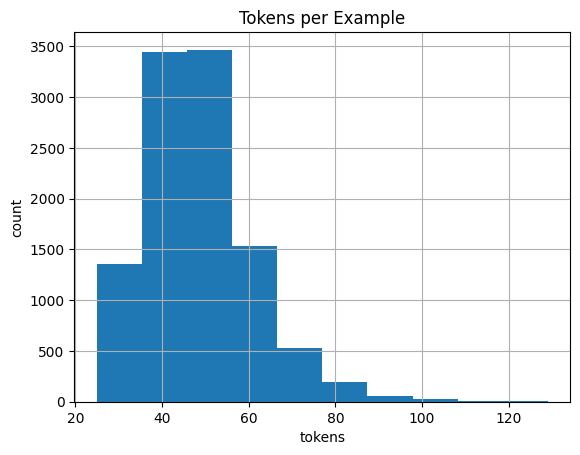

In [15]:
import matplotlib.pyplot as plt

# Tokens distribution
plt.figure()
df['tokens'].hist()
plt.title("Tokens per Example")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()